# Week 5 Problem 2

A few things you should keep in mind when working on assignments:

1. Make sure you fill in any place that says YOUR CODE HERE. Do not write your answer in anywhere else other than where it says YOUR CODE HERE. Anything you write anywhere else will be removed or overwritten by the autograder.

2. Before you submit your assignment, make sure everything runs as expected. Go to menubar, select Kernel, and restart the kernel and run all cells (Restart & Run all).

3. Do not change the title (i.e. file name) of this notebook.

4. Make sure that you save your work (in the menubar, select File → Save and CheckPoint)

5. When you are ready to submit your assignment, go to Dashboard → Assignments and click the Submit button. Your work is not submitted until you click Submit.

6. You are allowed to submit an assignment multiple times, but only the most recent submission will be graded.

7. If your code does not pass the unit tests, it will not pass the autograder.



# Due Date: 6 PM, February 19, 2018


In [1]:
# Set up Notebook

% matplotlib inline

# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from time import time
from sklearn.datasets import load_breast_cancer
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

from numpy.testing import assert_array_equal, assert_array_almost_equal
from pandas.util.testing import assert_frame_equal, assert_index_equal
from nose.tools import assert_false, assert_equal, assert_almost_equal, assert_true, assert_in, assert_is_not

# We do this to ignore several specific Pandas warnings
import warnings
warnings.filterwarnings("ignore")

# Set global figure properties
import matplotlib as mpl
mpl.rcParams.update({'axes.titlesize' : 20,
                     'axes.labelsize' : 18,
                     'legend.fontsize': 16})

# Set default seaborn plotting style
sns.set_style('white')

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import math
def confusion(test, predict, names, bins=3, title='Confusion Matrix'):

    # Make a 2D histogram from the test and result arrays
    pts, xe, ye = np.histogram2d(test, predict, bins)

    # For simplicity we create a new DataFrame
    pd_pts = pd.DataFrame(pts.astype(int), index=names, columns=names )
    
    # Display heatmap and add decorations
    sns.set(font_scale=1.5)
    hm = sns.heatmap(pd_pts, annot=True, fmt="d")
    
    sns.set(font_scale=2.0)
    hm.axes.set_title(title)
    hm.axes.set_xlabel('Predicted')
    hm.axes.set_ylabel('Actual')
    sns.set(font_scale=1.0)

    return None


## Breast Cancer Dataset

We will be using the built-in dataset about breast cancer and the respective information on indivudal breast cancer cases. This dataset has 569 samples and a dimensionality size of 30. We will be using only the 1st 10 features in order to create a Gradient Boosting model that will predict whether the individual case is either malignant (harmful) or benign (non-harmful).

The following code below imports the dataset as a pandas dataframe. It also concatenates a column called classification which contains whether the record was determined to be a malignant or benign tumor. Note: In this dataset, a malignant tumor has a value of 0 and a benign tumor has a value of 1.



In [2]:
# Load in the dataset as a Pandas DataFrame
data = load_breast_cancer()
cancer_data = pd.DataFrame(data.data, columns=data.feature_names)
cancer_data['target'] = data.target
# View the label distribution
print(cancer_data.target.value_counts(ascending=True))

features = cancer_data[cancer_data.columns[:10]]
labels = cancer_data.target
# Count the number of features
print("Number of features:", len(features.columns))


0    212
1    357
Name: target, dtype: int64
Number of features: 10


# Problem 1

Implement a Naive Bayes' model using below dataset(df) to calculate the probabilities and use this to predict the probabilities for each class happening for the test condition ***X=(age=youth,income=medium,student=yes,credit_rating=fair)***. 
Finally, you will have to find ***P(Class=yes|X)*** which is basically the probability of X falling in class 'yes' and ***P(Class=no|X)***  which is basically the probability of X falling in class 'no'. 

Later on in the next problem, we will fit a Naive Bayes' model to the same data set using GaussianNB and see if we get the same results.


In [3]:
import pandas as pd
    
data = pd.read_csv('/home/data_scientist/data/misc/table.csv')
df = data[:-1]
df

,age,income,student,credit_rating,Class
0,youth,high,no,fair,no
1,youth,high,no,excellent,no
2,middle_aged,high,no,fair,yes
3,senior,medium,no,fair,yes
4,senior,low,yes,fair,yes
5,senior,low,yes,excellent,no
6,middle_aged,low,yes,excellent,yes
7,youth,medium,no,fair,no
8,youth,low,yes,fair,yes
9,senior,medium,yes,fair,yes


In [4]:
def predict_probability(data):
    '''
    Since you have to predict Class for X=(age=youth,income=medium,student=yes,credit_rating=fair) 
    Calculate following : 
    
    P(Class=yes)
    P(Class=no)
    P(age=youth∣Class=yes)
    P(age=youth∣Class=no)
    P(income=medium∣Class=yes)
    P(income=medium∣Class=no)
    P(student=yes∣Class=yes)
    P(student=yes∣Class=no)
    P(credit_rating=fair∣Class=yes)
    P(credit_rating=fair∣Class=no)
    P(X∣Class=yes) = P(age=youth∣Class=yes)*P(income=medium∣Class=yes)
                                                        *P(student=yes∣Class=yes)*P(credit_rating=fair∣Class=yes)
    P(X∣Class=no) = P(age=youth∣Class=no)*P(income=medium∣Class=no)
                                                        *P(student=yes∣Class=no)*P(credit_rating=fair∣Class=no)                                                    
    
    P(Class=yes|X) = (P(X∣Class=yes)*P(Class=yes))/P(X)
    P(Class=no|X) = (P(X∣Class=no)*P(Class=no))/P(X)
    P(X) = (P(X∣Class=yes)*P(Class=yes))+(P(X∣Class=no)*P(Class=no))
    
    Parameters
    ----------
    data : dataset to be used for probability calculations
    
    Returns
    -------
    A tuple of 4 containing the predicted probabilities 
    of P(X∣Class=no), P(X∣Class=yes), 
    P(Class=yes|X) and P(Class=no|X) respectively
    
    Example Calculation
    -------------------
    P(Class=yes) = sum(data["Class"]=='yes')/len(data)
    P(age=youth∣buys_computer=yes) = sum(data[data["Class"]=='yes']["age"]=='youth')/sum(data["Class"]=='yes')
    '''
    
    # YOUR CODE HERE
    P_cyes = sum(data['Class']=='yes')/len(data)
    P_cno = 1-P_cyes
    P_youth_cyes = sum(data[data['Class']=='yes']['age']=='youth')/sum(data['Class']=='yes')
    P_youth_cno = sum(data[data['Class']=='no']['age']=='youth')/sum(data['Class']=='no')
    P_medium_cyes = sum(data[data['Class']=='yes']['income']=='medium')/sum(data['Class']=='yes')
    P_medium_cno = sum(data[data['Class']=='no']['income']=='medium')/sum(data['Class']=='no')
    P_syes_cyes = sum(data[data['Class']=='yes']['student']=='yes')/sum(data['Class']=='yes')
    P_syes_cno = sum(data[data['Class']=='no']['student']=='yes')/sum(data['Class']=='no')
    P_fair_cyes = sum(data[data['Class']=='yes']['credit_rating']=='fair')/sum(data['Class']=='yes')
    P_fair_cno = sum(data[data['Class']=='no']['credit_rating']=='fair')/sum(data['Class']=='no')
    P_X_cyes = P_youth_cyes*P_medium_cyes*P_syes_cyes*P_fair_cyes
    P_X_cno = P_youth_cno*P_medium_cno*P_syes_cno*P_fair_cno                                                    
    
    P_X = (P_X_cyes*P_cyes)+(P_X_cno*P_cno)
    P_cyes_X = P_X_cyes*P_cyes/P_X
    P_cno_X = P_X_cno*P_cno/P_X
    
    return P_X_cno, P_X_cyes, P_cno_X, P_cyes_X

In [5]:
probs = predict_probability(df)
assert_equal(isinstance(probs, tuple), True)
assert_almost_equal(0.195, probs[2], 3)
assert_almost_equal(0.805, probs[3], 3)

# Problem 2

Create a Naive Bayes' classifier for the above data set and return the predicted probabilities for each class. We will see that the predictions using GaussianNB and the predictions we found in Problem 1 are similar.

In [6]:
import patsy as pts 

y, x = pts.dmatrices('Class ~ C(age) + C(credit_rating) + ' +
                     'C(income) + C(student)',
                     data=data, return_type='dataframe')


y_test = y[-1:]
y_train = y[:-1]
x_test = x[-1:]
x_train = x[:-1]


In [17]:
def gnb_model(x_train, y_train, x_test):
    '''    
    Fit a general naive bayes' Classifier and return the predicted probabilities for each class 
    
    Parameters
    ----------
    x_train : independent data for train dataset
    y_train : dependent data for test dataset
    x_test : independent data for test dataset
    
    Returns
    -------
    A tuple of 2 containing the predicted probabilities for the test dataset
    '''
    
    # YOUR CODE HERE
    nbc = GaussianNB()
    nbc = nbc.fit(x_train, y_train)
    pred = nbc.predict_proba(x_test)
    
    return pred


In [18]:
probs2 = gnb_model(x_train, y_train['Class[yes]'], x_test)
assert_equal(isinstance(probs2, np.ndarray), True)
assert_almost_equal(probs2[0][0], probs[2], 2)
assert_almost_equal(probs2[0][1], probs[3], 2)

# Problem3

Create Naive Bayes' model using [MultinomialNB](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html) and [GaussianNB](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html) using prior probability as hyper-parameter in both the models. Fit the model on the training set for the ***Breast Cancer dataset***. We will see how we can change prior probabilities to catch more number of malignant tumor cases.



In [19]:
test_frac = 0.4
X_train, X_test, y_train, y_test = train_test_split(features, labels, 
                                                    test_size=test_frac, random_state=40)

def mnb(ind_train, dep_train , prior):
    '''
    Create Naive Bayes' model using MultinomialNB and GaussianNB using prior probability as hyper-parameter 
    in both the models. Fit the model on the training set.
    
    Hint: Look at the documentation of both the functions to check which hyper-parameter to use. 
    
    Parameters
    ----------
    ind_train : independent training dataset
    dep_train : dependent training dataset
    prior : array defining prior probability of each class
    
    Returns
    -------
    A tuple of 2 returning the fitted model for MultinomialNB and GaussianNB respectively
    '''

    # YOUR CODE HERE
    mnb = MultinomialNB(class_prior=prior)
    gnb = GaussianNB(priors=prior)
    
    mnb = mnb.fit(ind_train, dep_train)
    gnb = gnb.fit(ind_train, dep_train)
    
    return mnb, gnb

In [20]:
prior = [0.8, 0.2]
model = mnb(X_train, y_train, prior)
predicted0 = model[0].predict(X_test)
predicted1 = model[1].predict(X_test)
assert_equal(isinstance(model[0], MultinomialNB), True)
assert_equal(isinstance(model[1], GaussianNB), True)
assert_almost_equal(0.833, accuracy_score(y_test, predicted0), 3)

You can see from the confusion matrix shown below, that since the data was continuous, Gaussian Naive Bayes' gives us better results. Also, the 2nd example of GaussianNB confusion matrix shows us that for cases like Breast Cancer Prediction, where its better to catch all Malignant tumors, we can set the prior probability of Malignant to be higher.

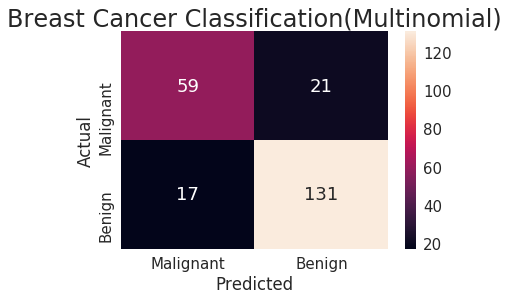

In [21]:
confusion(y_test.reshape(y_test.shape[0]), predicted0, ['Malignant', 'Benign'], 2, \
          'Breast Cancer Classification(Multinomial)')

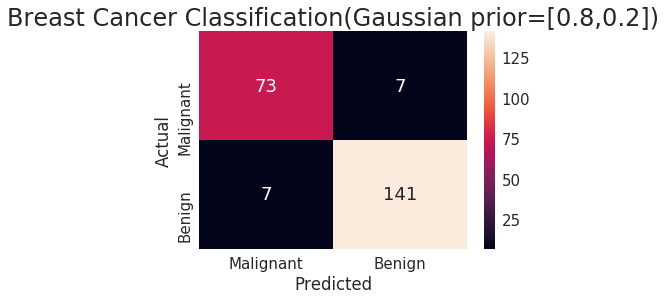

In [22]:
confusion(y_test.reshape(y_test.shape[0]), predicted1, ['Malignant', 'Benign'], 2, \
          'Breast Cancer Classification(Gaussian prior=[0.8,0.2])')

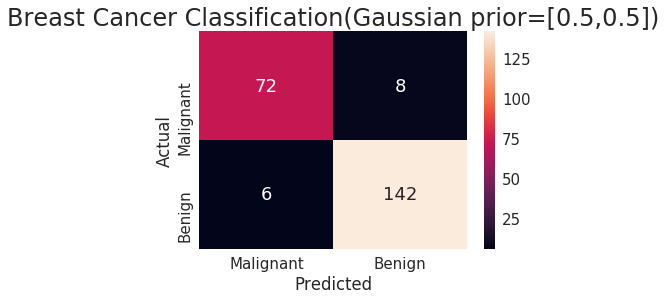

In [23]:
prior = [0.5, 0.5]
model2 = mnb(X_train, y_train, prior)
predicted2 = model2[1].predict(X_test)
confusion(y_test.reshape(y_test.shape[0]), predicted2, ['Malignant', 'Benign'], 2, \
          'Breast Cancer Classification(Gaussian prior=[0.5,0.5])')